# **3D CNN from CT**

# Set up

In [1]:
import os
import zipfile
import numpy as np
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init
import torch.utils.model_zoo
import torch.nn.functional
import matplotlib.pyplot as plt

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 랜덤 시드 고정
torch.manual_seed(42)
np.random.seed(42)

# GPU 사용 가능일 경우 랜덤 시드 고정
if device == 'cuda':
    torch.cuda.manual_seed_all(42)

# Downroad data

In [5]:
# Download url of normal CT scans.
url = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-0.zip"
filename = os.path.join(os.getcwd(), "CT-0.zip")
try :
  torch.utils.model_zoo.load_url(url, file_name=filename)
except :
  pass

# Download url of abnormal CT scans.
url = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-23.zip"
filename = os.path.join(os.getcwd(), "CT-23.zip")
try :
  torch.utils.model_zoo.load_url(url, file_name=filename)
except :
  pass

# Make a directory to store the data.
os.makedirs("MosMedData")

# Unzip data in the newly created directory.
with zipfile.ZipFile("CT-0.zip", "r") as z_fp:
    z_fp.extractall("./MosMedData/")

with zipfile.ZipFile("CT-23.zip", "r") as z_fp:
    z_fp.extractall("./MosMedData/")
  

Downloading: "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-0.zip" to /content/CT-0.zip


  0%|          | 0.00/0.99G [00:00<?, ?B/s]

Downloading: "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-23.zip" to /content/CT-23.zip


  0%|          | 0.00/997M [00:00<?, ?B/s]

# Preprocessing

In [6]:
import nibabel as nib

from scipy import ndimage


def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan


def normalize(volume):
    """Normalize the volume"""
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume


def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img


def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    # Normalize
    volume = normalize(volume)
    # Resize width, height and depth
    volume = resize_volume(volume)
    # Reshape to (Depth, Height, Width)
    volume = volume.reshape((volume.shape[-1],volume.shape[1],volume.shape[0]))
    volume = np.expand_dims(volume, axis = 0)
    return volume

In [7]:
# Folder "CT-0" consist of CT scans having normal lung tissue,
# no CT-signs of viral pneumonia.
normal_scan_paths = [
    os.path.join(os.getcwd(), "MosMedData/CT-0", x)
    for x in os.listdir("MosMedData/CT-0")
]
# Folder "CT-23" consist of CT scans having several ground-glass opacifications,
# involvement of lung parenchyma.
abnormal_scan_paths = [
    os.path.join(os.getcwd(), "MosMedData/CT-23", x)
    for x in os.listdir("MosMedData/CT-23")
]

print("CT scans with normal lung tissue: " + str(len(normal_scan_paths)))
print("CT scans with abnormal lung tissue: " + str(len(abnormal_scan_paths)))


CT scans with normal lung tissue: 100
CT scans with abnormal lung tissue: 100


In [8]:
  # Read and process the scans.
  # Each scan is resized across height, width, and depth and rescaled.
  abnormal_scans = np.array([process_scan(path) for path in abnormal_scan_paths])
  normal_scans = np.array([process_scan(path) for path in normal_scan_paths])

  # For the CT scans having presence of viral pneumonia
  # assign 1, for the normal ones assign 0.
  abnormal_labels = np.array([1 for _ in range(len(abnormal_scans))],dtype = np.float32)
  normal_labels = np.array([0 for _ in range(len(normal_scans))],dtype = np.float32)

  # Split data in the ratio 70-30 for training and validation.
x_train = np.concatenate((abnormal_scans[:70], normal_scans[:70]), axis=0)
y_train = np.concatenate((abnormal_labels[:70], normal_labels[:70]), axis=0)
x_val = np.concatenate((abnormal_scans[70:], normal_scans[70:]), axis=0)
y_val = np.concatenate((abnormal_labels[70:], normal_labels[70:]), axis=0)
print(
    "Number of samples in train and validation are %d and %d."
    % (x_train.shape[0], x_val.shape[0])
)

Number of samples in train and validation are 140 and 60.


# Data to Data loader

In [9]:
  # Split data in the ratio 70-30 for training and validation.
x_train = torch.from_numpy(np.concatenate((abnormal_scans[:70], normal_scans[:70]), axis=0))
y_train = torch.from_numpy(np.concatenate((abnormal_labels[:70], normal_labels[:70]), axis=0))
x_val = torch.from_numpy(np.concatenate((abnormal_scans[70:], normal_scans[70:]), axis=0))
y_val = torch.from_numpy(np.concatenate((abnormal_labels[70:], normal_labels[70:]), axis=0))
print(
    "Number of samples in train and validation are %d and %d."
    % (x_train.shape[0], x_val.shape[0])
)

Number of samples in train and validation are 140 and 60.


In [10]:
from torch.utils.data import TensorDataset # 텐서데이터셋
from torch.utils.data import DataLoader # 데이터로더

train_dataset = TensorDataset(x_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)

valid_dataset = TensorDataset(x_val, y_val)
valid_dataloader = DataLoader(valid_dataset, batch_size=2, shuffle=True)

# Hyperparameter set up 

In [21]:
learning_rate = 0.0001
training_epochs = 60

# 3D-CNN model defination

In [12]:
class cnn_3d_model(torch.nn.Module):

    def __init__(self):
        super(cnn_3d_model, self).__init__()

        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv3d(1, 64, kernel_size=3),
            torch.nn.ReLU(),
            torch.nn.MaxPool3d(kernel_size=2, stride=2),
            torch.nn.BatchNorm3d(num_features = 64)
            )
        

        self.layer2_1 = torch.nn.Sequential(
            torch.nn.Conv3d(64, 64, kernel_size = 3,padding = 1),
            torch.nn.ReLU(),
            torch.nn.Conv3d(64, 64, kernel_size = 3,padding = 1),
            )
        
        self.layer2_2 =torch.nn.Sequential(
            torch.nn.MaxPool3d(kernel_size=2, stride=2),
            torch.nn.BatchNorm3d(num_features = 64)
            )
        

        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv3d(64, 128, kernel_size=3),
            torch.nn.ReLU(),
            torch.nn.MaxPool3d(kernel_size=2, stride=2),
            torch.nn.BatchNorm3d(num_features = 128)
            )    
        
        self.layer4 = torch.nn.Sequential(
            torch.nn.Conv3d(128, 256, kernel_size=3),
            torch.nn.ReLU(),
            torch.nn.MaxPool3d(kernel_size=2, stride=2),
            torch.nn.BatchNorm3d(num_features = 256)
            )
        
        # global average pool 은 forward에서 


        self.layer_fc1 = torch.nn.Sequential(
            torch.nn.Linear(256, 512),
            torch.nn.ReLU() 
        )

        self.layer_fc2 = torch.nn.Sequential(
            torch.nn.Linear(512, 1),
            torch.nn.Sigmoid() 
        )

    def forward(self, x):
        out_ = self.layer1(x)
        out = self.layer2_1(out_)
        out = out + out_
        out = self.layer2_2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.shape[0],-1, 256)   # globalaveragepooling 과정1
        out = torch.mean(out,1)   # globalaveragepooling 과정2
        out = self.layer_fc1(out)
        out = torch.nn.Dropout(p=0.3)(out)
        out = self.layer_fc2(out)
        return out

In [22]:
model = cnn_3d_model().to(device)

In [23]:
criterion = torch.nn.BCELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Model training

In [24]:
losses = []
losses_val = []
acc_val = []

for epoch in range(training_epochs):
    avg_cost = 0
    train_len = len(train_dataloader)
    val_len = len(valid_dataloader)

    for X, Y in train_dataloader: # 미니 배치 단위로 꺼내온다. X는 미니 배치, Y는 레이블.
        # image is already size of (28x28), no reshape
        # label is not one-hot encoded
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = model(X)
        cost = criterion(hypothesis.ravel(), Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / train_len

    losses.append(avg_cost.cpu().item())

    with torch.no_grad():
      avg_cost = 0
      correct = 0
      for X, Y in valid_dataloader:
        X = X.to(device)
        Y = Y.to(device)
        
        hypothesis = model(X)
        cost = criterion(hypothesis.ravel(), Y)

        avg_cost += cost / val_len

        predicted = (hypothesis > 0.5).float().ravel()
        correct += (predicted == Y).sum().item()

      acc_val.append(correct)

      losses_val.append(avg_cost.cpu().item())


# Visualizing model peformance

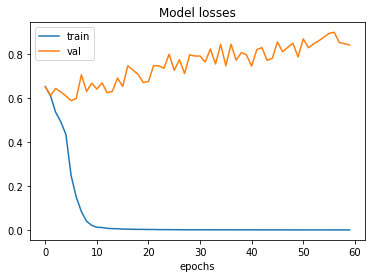

In [31]:
plt.plot(losses)
plt.plot(losses_val)
plt.title("Model losses")
plt.xlabel("epochs")
plt.legend(["train", "val"])

In [33]:
print(losses)

[0.6518648266792297, 0.611200749874115, 0.5360328555107117, 0.4926435351371765, 0.4341389536857605, 0.24809885025024414, 0.14990739524364471, 0.08342189341783524, 0.03959263116121292, 0.020779579877853394, 0.012285488657653332, 0.011067871004343033, 0.007411203812807798, 0.006064307875931263, 0.005531026050448418, 0.00399013701826334, 0.003489759285002947, 0.0030365039128810167, 0.0027315921615809202, 0.0026266900822520256, 0.0019362635212019086, 0.0021613705903291702, 0.001464101835153997, 0.001437970669940114, 0.0014722495106980205, 0.0011734949657693505, 0.0010252982610836625, 0.0008426624117419124, 0.0008620826411060989, 0.0007487821858376265, 0.0007835400174371898, 0.0007497442420572042, 0.000831437879242003, 0.0005406693671829998, 0.0005540932761505246, 0.0006354140932671726, 0.0005517045501619577, 0.0004375384305603802, 0.00045474382932297885, 0.00046863031457178295, 0.00037266177241690457, 0.0003679704386740923, 0.00031571206636726856, 0.0003189725975971669, 0.00030686947866342

In [34]:
print(losses_val)

[0.6520937085151672, 0.6107217073440552, 0.643854022026062, 0.6280462741851807, 0.6097981333732605, 0.5882202386856079, 0.5979469418525696, 0.7063540816307068, 0.6301725506782532, 0.6682202219963074, 0.640937328338623, 0.669455349445343, 0.6241245269775391, 0.6310354471206665, 0.6910175085067749, 0.6528967618942261, 0.7470521330833435, 0.7272776961326599, 0.7075871825218201, 0.6709694266319275, 0.6754607558250427, 0.7480673789978027, 0.7464994192123413, 0.7357330322265625, 0.7996067404747009, 0.7266739010810852, 0.7747170329093933, 0.7116649150848389, 0.7970539331436157, 0.7914073467254639, 0.7913716435432434, 0.764055073261261, 0.8235607743263245, 0.7554628849029541, 0.8443452715873718, 0.7476187348365784, 0.8449795246124268, 0.7723921537399292, 0.8071632385253906, 0.7965564727783203, 0.7456313967704773, 0.8206340670585632, 0.8296554088592529, 0.7716848254203796, 0.7809228301048279, 0.855232834815979, 0.8108013272285461, 0.8310322761535645, 0.8494510650634766, 0.7869012355804443, 0.86

In [35]:
print(model)

cnn_3d_model(
  (layer1): Sequential(
    (0): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2_1): Sequential(
    (0): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): ReLU()
    (2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  )
  (layer2_2): Sequential(
    (0): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer3): Sequential(
    (0): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (l